In [1]:
%load_ext autoreload
%autoreload 2
import tnetwork as tn
import tnetwork.DCD as DCD
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
from tnetwork.experiments.experiments import *
import matplotlib.pyplot as plt
import datetime
from tnetwork.DCD.externals import *

In [2]:
import os
#dir_or = os.path.dirname(__file__)
dir_or = "/Users/remycazabet/Documents/GitHub/tnetwork/article2020/xp"

In [3]:
from matlab import engine

eng = engine.start_matlab()
elapsed_time=True
def iterative(x, elapsed_time=elapsed_time):
    return tn.DCD.iterative_match(x, elapsed_time=elapsed_time)
def smoothed_louvain(x, elapsed_time=True):
    return tn.DCD.smoothed_louvain(x, elapsed_time=elapsed_time)
def DYNAMO(x, elapsed_time=True):
    return tn.DCD.externals.dynamo(x, elapsed_time=elapsed_time,timeout=100)
def smoothed_graph(x, elapsed_time=True):
    return tn.DCD.smoothed_graph(x, elapsed_time=elapsed_time, alpha=0.9)

#def estrangement_confinement(x, elapsed_time=True):
#    return tn.DCD.externals.estrangement_confinement(x, elapsed_time=elapsed_time,minrepeats=2,increpeats=2,maxfun=300)
def transversal_network(x, elapsed_time=True):
    #return tn.DCD.externals.transversal_network_leidenalg(x, interslice_weight=0.5,elapsed_time=elapsed_time)
    return tn.DCD.externals.transversal_network_mucha_original(x, elapsed_time=elapsed_time,om=0.5, matlab_session=eng)
def label_smoothing(x, elapsed_time=True):
    #return tn.DCD.externals.transversal_network_leidenalg(x, interslice_weight=0.5,elapsed_time=elapsed_time)
    return tn.DCD.match_survival_graph(x, elapsed_time=elapsed_time)


methods_to_test = { "smoothed-graph":smoothed_graph,
                   "implicit-global": smoothed_louvain,
                   "no-smoothing":iterative,
                   "DYNAMO":DYNAMO,
                   "transversal-network":transversal_network,
                   "label-smoothing":label_smoothing
                  }
#methods_to_test = {"smoothed-graph":smoothed_graph}

#methods_to_test = {
#                   "implicit-global": smoothed_louvain,
#                   "no-smoothing":iterative,
#                   "DYNAMO":DYNAMO,
#                   "label-smoothing":label_smoothing
#                  }

# Qualitative analysis

In [3]:
dyn_graph_sharp,dyn_com_sharp= generate_toy_example(random_noise=0, external_density_penalty=0.05,alpha=0.9)
dyn_graph_blurred,dyn_com_blurred= generate_toy_example(random_noise=0, external_density_penalty=0.25,alpha=0.8)

100% (26 of 26) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


ColumnDataSource(id='1002', ...)


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


ColumnDataSource(id='1003', ...)


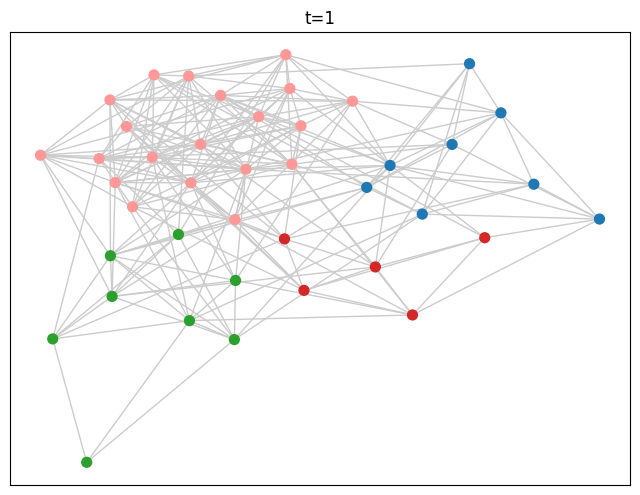

In [4]:
p = tn.plot_longitudinal(dyn_graph_sharp,dyn_com_sharp)
p.savefig("article2020/xp/GT.png")
p = tn.plot_as_graph(dyn_graph_sharp,dyn_com_sharp,ts=1)
p.savefig("article2020/xp/sharp.png")
plt.clf()
p = tn.plot_as_graph(dyn_graph_blurred,dyn_com_blurred,ts=1)
p.savefig("article2020/xp/blurred.png")

In [81]:

run_all_algos(methods_to_test,dyn_graph_sharp,plot=os.path.join(dir_or,"sharp"))


preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


{'transversal-network': (<tnetwork.dyn_community.communities_dyn_sn.DynCommunitiesSN at 0x135ccf350>,
  {'total': 1.8197810649871826})}

<Figure size 800x600 with 0 Axes>

In [82]:
run_all_algos(methods_to_test,dyn_graph_blurred,plot=os.path.join(dir_or,"blurred"))



preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


{'transversal-network': (<tnetwork.dyn_community.communities_dyn_sn.DynCommunitiesSN at 0x1446d2690>,
  {'total': 2.336134910583496})}

<Figure size 800x600 with 0 Axes>

# Quantitative analysis

In [4]:
def compute_communities_on_random_graph(mus,nb_coms=[10],subsets=None,iterations=2,min_size=5,max_size=15,operations=20):
    saved_coms = {}

    if subsets==None:
        subsets=[None]
    for mu in mus:
        print("----",mu)

        for iteration in range(iterations):
            for nb_com in nb_coms:
                print(iteration)
                (dyn_graph,GT) = generate_graph(nb_com,min_size,max_size,operations,mu_noise=0.01,mu=mu,alpha=1)


                dyn_graph_sn = dyn_graph.to_DynGraphSN(slices=1)
                GT_as_sn = GT.to_DynCommunitiesSN(slices=1)

                    
                for length in subsets:
                    ID = (mu,iteration,nb_com,length)
                    saved_coms[ID]={}
                    saved_coms[ID]["ID"]={"mu":ID[0],"iteration":ID[1],"#coms":nb_com}
                    if length==None:
                        subgraph = dyn_graph_sn
                        subcomsGT = GT_as_sn
                    else:
                        subgraph,subcomsGT =subset(dyn_graph_sn,GT_as_sn,length)

                    saved_coms[ID]["graph"]=subgraph
                    saved_coms[ID]["GT"]=subcomsGT

                    try:
                        result = run_all_algos(methods_to_test,subgraph)
                        saved_coms[ID]["result"]=result
                    except:
                        print("error computing algos")
    return saved_coms

In [5]:
from os import listdir
from os.path import isfile, join
def load_all_files(keyword):
    """
    Function to load all files with a given keyword and concatenate their csvs"""
    mypath = dir_or
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    all_pds = []
    for fil in onlyfiles:
        if keyword in fil:
            a_pd = pd.read_csv(mypath+"/"+fil,index_col=0)
            a_pd["file"]=fil
            all_pds.append(a_pd)
            print(len(a_pd))
    df_stats = pd.concat(all_pds)
    return df_stats


# Computing community qualities

## generate graphs and run algorithms

In [6]:
df_stats = None
mus = [0,0.05]+[0.1,0.15,0.2]+[0.3,0.4,0.5]
#mus = [0.05,0.1,0.15]
#mus = [0.3,0.4]
saved_coms = compute_communities_on_random_graph(mus,iterations=5)


 30% (6 of 20) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

---- 0
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (1319 of 1322) |################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start smoothed louvain


 99% (1316 of 1322) |################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:07 ETA:  00:00:00

start smoothed graph


 99% (1691 of 1692) |################### | Elapsed Time: 0:00:39 ETA:   0:00:00

start smoothed louvain


 99% (1685 of 1692) |################### | Elapsed Time: 0:00:20 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:10 ETA:  00:00:00

start smoothed graph


 99% (1883 of 1884) |################### | Elapsed Time: 0:00:56 ETA:   0:00:00

start smoothed louvain


100% (1884 of 1884) |####################| Elapsed Time: 0:00:26 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:08 ETA:  00:00:00

start smoothed graph


 99% (2103 of 2106) |################### | Elapsed Time: 0:00:52 ETA:   0:00:00

start smoothed louvain


100% (2106 of 2106) |####################| Elapsed Time: 0:00:23 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


 99% (812 of 817) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

start smoothed louvain


 98% (807 of 817) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

---- 0.05
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


 99% (1337 of 1339) |################### | Elapsed Time: 0:00:38 ETA:   0:00:00

start smoothed louvain


100% (1339 of 1339) |####################| Elapsed Time: 0:00:19 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 20% (4 of 20) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:09 ETA:  00:00:00

start smoothed graph


100% (1237 of 1237) |####################| Elapsed Time: 0:00:43 ETA:  00:00:00

start smoothed louvain


100% (1237 of 1237) |####################| Elapsed Time: 0:00:18 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:06 ETA:  00:00:00

start smoothed graph


100% (1346 of 1346) |####################| Elapsed Time: 0:00:47 ETA:  00:00:00

start smoothed louvain


100% (1346 of 1346) |####################| Elapsed Time: 0:00:20 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:10 ETA:  00:00:00

start smoothed graph


 99% (1297 of 1299) |################### | Elapsed Time: 0:00:36 ETA:   0:00:00

start smoothed louvain


 99% (1293 of 1299) |################### | Elapsed Time: 0:00:16 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 30% (6 of 20) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (1121 of 1122) |################### | Elapsed Time: 0:00:18 ETA:   0:00:00

start smoothed louvain


 99% (1116 of 1122) |################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

---- 0.1
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

start smoothed graph


 99% (801 of 803) |##################### | Elapsed Time: 0:00:17 ETA:   0:00:00

start smoothed louvain


 98% (793 of 803) |##################### | Elapsed Time: 0:00:07 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


 99% (1369 of 1370) |################### | Elapsed Time: 0:00:39 ETA:   0:00:00

start smoothed louvain


 99% (1362 of 1370) |################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (1026 of 1027) |################### | Elapsed Time: 0:00:26 ETA:   0:00:00

start smoothed louvain


100% (1027 of 1027) |####################| Elapsed Time: 0:00:10 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

start smoothed graph


 99% (1202 of 1204) |################### | Elapsed Time: 0:00:28 ETA:   0:00:00

start smoothed louvain


100% (1204 of 1204) |####################| Elapsed Time: 0:00:12 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

start smoothed graph


 99% (1059 of 1060) |################### | Elapsed Time: 0:00:38 ETA:   0:00:00

start smoothed louvain


 99% (1056 of 1060) |################### | Elapsed Time: 0:00:22 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

---- 0.15
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:10 ETA:  00:00:00

start smoothed graph


 99% (1935 of 1936) |################### | Elapsed Time: 0:01:12 ETA:   0:00:00

start smoothed louvain


100% (1936 of 1936) |####################| Elapsed Time: 0:00:45 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


100% (1206 of 1206) |####################| Elapsed Time: 0:00:36 ETA:  00:00:00

start smoothed louvain


 99% (1201 of 1206) |################### | Elapsed Time: 0:00:12 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


 99% (1385 of 1386) |################### | Elapsed Time: 0:00:41 ETA:   0:00:00

start smoothed louvain


 99% (1380 of 1386) |################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:07 ETA:  00:00:00

start smoothed graph


100% (1753 of 1753) |####################| Elapsed Time: 0:00:57 ETA:  00:00:00

start smoothed louvain


 99% (1748 of 1753) |################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

start smoothed graph


100% (808 of 808) |######################| Elapsed Time: 0:00:20 ETA:  00:00:00

start smoothed louvain


100% (808 of 808) |######################| Elapsed Time: 0:00:06 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

---- 0.2
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (863 of 865) |##################### | Elapsed Time: 0:00:25 ETA:   0:00:00

start smoothed louvain


 99% (860 of 865) |##################### | Elapsed Time: 0:00:08 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 20% (4 of 20) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

start smoothed graph


 99% (1357 of 1358) |################### | Elapsed Time: 0:00:58 ETA:   0:00:00

start smoothed louvain


100% (1358 of 1358) |####################| Elapsed Time: 0:00:15 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

start smoothed graph


 99% (652 of 654) |##################### | Elapsed Time: 0:00:18 ETA:   0:00:00

start smoothed louvain


100% (654 of 654) |######################| Elapsed Time: 0:00:06 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (863 of 864) |##################### | Elapsed Time: 0:00:32 ETA:   0:00:00

start smoothed louvain


 99% (861 of 864) |##################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

start smoothed graph


 99% (1165 of 1170) |################### | Elapsed Time: 0:00:38 ETA:   0:00:00

start smoothed louvain


 99% (1169 of 1170) |################### | Elapsed Time: 0:00:11 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00

---- 0.3
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


100% (646 of 646) |######################| Elapsed Time: 0:00:13 ETA:  00:00:00

start smoothed louvain


100% (646 of 646) |######################| Elapsed Time: 0:00:05 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

start smoothed graph


 99% (1252 of 1255) |################### | Elapsed Time: 0:00:37 ETA:   0:00:00

start smoothed louvain


 99% (1250 of 1255) |################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

start smoothed graph


 99% (581 of 583) |##################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start smoothed louvain


 98% (576 of 583) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:02 ETA:  00:00:00

start smoothed graph


 99% (555 of 557) |##################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start smoothed louvain


 98% (550 of 557) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:03 ETA:  00:00:00

start smoothed graph


 99% (1061 of 1065) |################### | Elapsed Time: 0:00:32 ETA:   0:00:00

start smoothed louvain


 99% (1063 of 1065) |################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 20% (4 of 20) |#####                    | Elapsed Time: 0:00:00 ETA:  00:00:00

---- 0.4
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (508 of 510) |##################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start smoothed louvain


 98% (504 of 510) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (594 of 596) |##################### | Elapsed Time: 0:00:21 ETA:   0:00:00

start smoothed louvain


 98% (588 of 596) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:56 ETA:  00:00:00

start smoothed graph


 99% (521 of 522) |##################### | Elapsed Time: 0:00:20 ETA:   0:00:00

start smoothed louvain


100% (522 of 522) |######################| Elapsed Time: 0:00:04 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (508 of 509) |##################### | Elapsed Time: 0:00:12 ETA:   0:00:00

start smoothed louvain


100% (509 of 509) |######################| Elapsed Time: 0:00:03 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 20% (4 of 20) |#####                    | Elapsed Time: 0:00:00 ETA:  00:00:00

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (530 of 533) |##################### | Elapsed Time: 0:00:16 ETA:   0:00:00

start smoothed louvain


 98% (527 of 533) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:  00:00:00

---- 0.5
0
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (539 of 540) |##################### | Elapsed Time: 0:00:14 ETA:   0:00:00

start smoothed louvain


 98% (534 of 540) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 40% (8 of 20) |##########               | Elapsed Time: 0:00:00 ETA:   0:00:00

1
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (577 of 581) |##################### | Elapsed Time: 0:00:18 ETA:   0:00:00

start smoothed louvain


 97% (567 of 581) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 25% (5 of 20) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

2
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (463 of 464) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

start smoothed louvain


 98% (459 of 464) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 30% (6 of 20) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

3
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:01 ETA:  00:00:00

start smoothed graph


 99% (508 of 510) |##################### | Elapsed Time: 0:00:12 ETA:   0:00:00

start smoothed louvain


100% (510 of 510) |######################| Elapsed Time: 0:00:02 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


 45% (9 of 20) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

4
generating graph with nb_com =  10


100% (20 of 20) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

start smoothed graph


 98% (356 of 360) |##################### | Elapsed Time: 0:00:08 ETA:   0:00:00

start smoothed louvain


 98% (356 of 360) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


## Save results and compute stats

In [7]:
#import datetime
#globalID=datetime.datetime.now().strftime("%m-%d-%Y:%I:%M%p")
#pickle.dump(saved_coms,open(dir_or+"/saved_coms"+str(globalID),"wb"))


In [202]:
#len(saved_coms)

9

In [7]:
df_stats = compute_all_stats(saved_coms)
#df_stats = compute_all_stats({(0.2,2):saved_coms[(0.15,3)]})

(0, 0, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0, 1, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0, 2, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0, 3, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0, 4, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.05, 0, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.05, 1, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.05, 2, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.05, 3, 10, None)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.05, 4, 10, None)
smoothed-graph
implicit-global
n

In [8]:
globalID=datetime.datetime.now().strftime("%m-%d-%Y:%I:%M%p")
df_stats.to_csv(dir_or+"/data"+str(globalID))

## Visualize results
First with the longitudinal plots

In [10]:
df_stats = load_all_files("data")

9
18
18
54
54
30
240
80
1
60
54
282
9
60


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


<Figure size 1080x360 with 0 Axes>

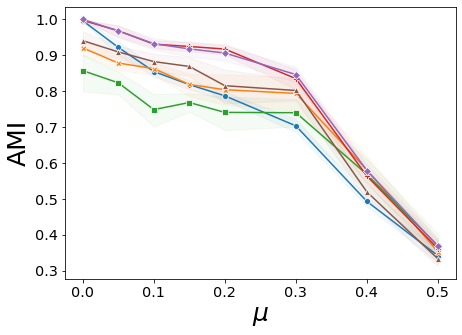

<Figure size 288x216 with 0 Axes>

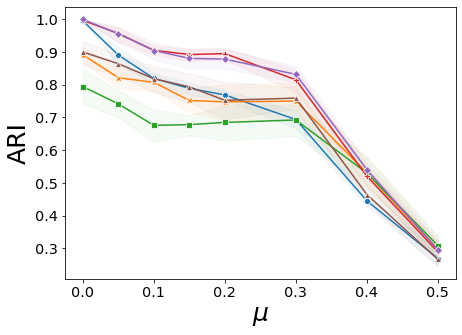

<Figure size 288x216 with 0 Axes>

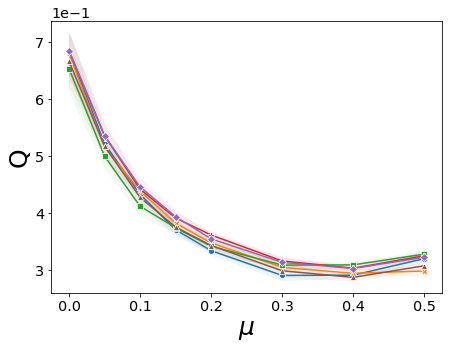

<Figure size 288x216 with 0 Axes>

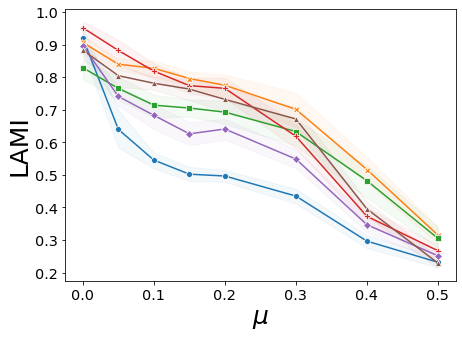

<Figure size 288x216 with 0 Axes>

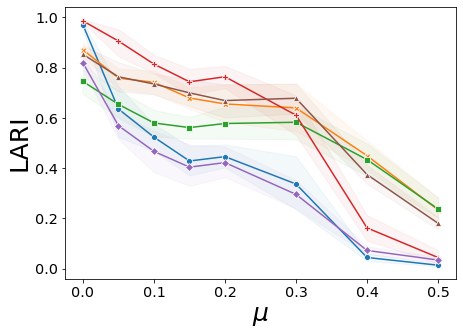

<Figure size 288x216 with 0 Axes>

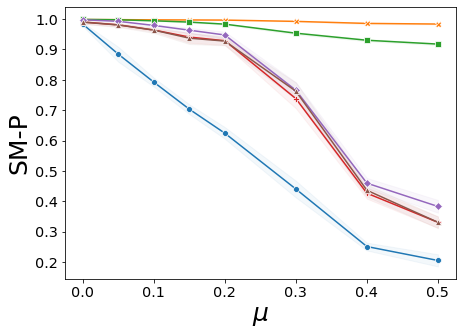

<Figure size 288x216 with 0 Axes>

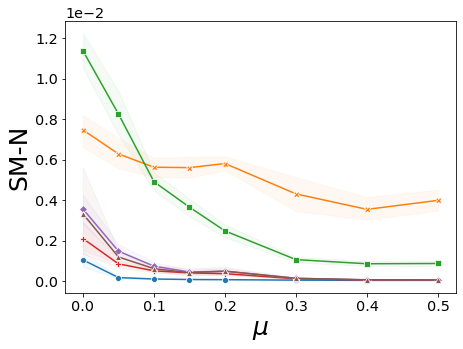

<Figure size 288x216 with 0 Axes>

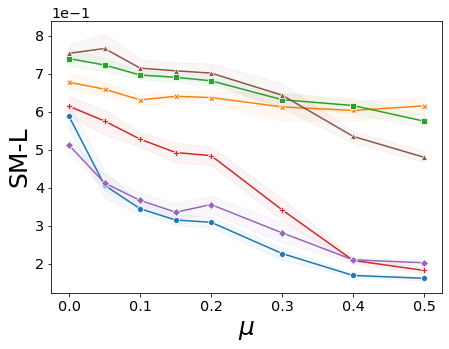

<Figure size 288x216 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

df_stats["SM-L"] = 1/(1+df_stats["SM-L"])
df_stats["SM-N"] = 1/df_stats["SM-N"]
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["AMI","ARI","Q","LAMI","LARI","SM-P","SM-N","SM-L"]:
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = sns.lineplot(x="mu", y=carac, ax=ax,hue="algorithm",style="algorithm",legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("$\mu$", fontsize=25)
    ax.set_ylabel(carac, fontsize=25)
    ax.set_xticks(np.arange(0.0, 0.51, 0.1))
    ax.ticklabel_format(axis="y",scilimits=(-1,1),style="sci")


    #ax.figure(figsize=(20,20))
    handles,labels = ax.get_legend_handles_labels()
    figlegend = pylab.figure(figsize=(4,3))
    figlegend.legend(handles,labels,loc="center")
    figlegend.savefig(dir_or+"/legend.pdf")
    ax.get_legend().remove()
    ax.get_figure().savefig(dir_or+"/"+carac+".pdf")




### Then visualize using a spider web plot

In [50]:
df_stats = df_stats.drop([0])

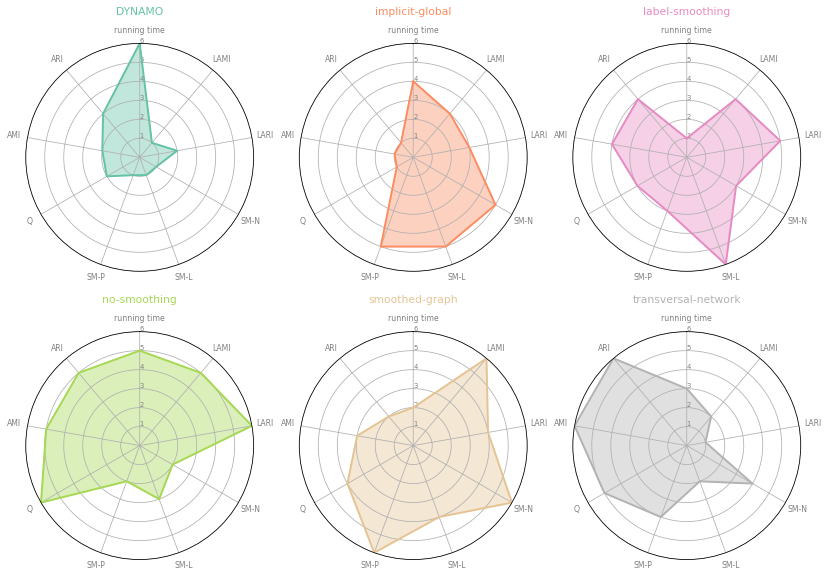

In [63]:
#df = pd.DataFrame({
#'group': ['A','B','C','D'],
#'var1': [38, 1.5, 30, 4],
#'var2': [29, 10, 9, 34],
#'var3': [8, 39, 23, 24],
#'var4': [7, 31, 33, 14],
#'var5': [28, 15, 32, 14]
#})
df = df_stats[df_stats["mu"]==0.2].groupby('algorithm', as_index=False).mean()
#df.droplevel(level=1)
#df = df_stats[df_stats["mu"]==0.2]
df['LAMI'] = df['LAMI'].rank(ascending=True)
df['LARI'] = df['LARI'].rank(ascending=True)
df['SM-N'] = df['SM-N'].rank(ascending=True)
df['SM-L'] = df['SM-L'].rank(ascending=True)
df['SM-P'] = df['SM-P'].rank(ascending=True)
df['Q'] = df['Q'].rank(ascending=True)
df['AMI'] = df['AMI'].rank(ascending=True)
df['ARI'] = df['ARI'].rank(ascending=True)
df['running time'] = df['running time'].rank(ascending=False)


df = df.drop(columns=["# nodes","# steps", "mu", "iteration"])

# ------- PART 1: Define a function that do a plot for one line of the dataset!

pi=3.14159
def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5,6], ["1","2","3","4","5","6"], color="grey", size=7)
    plt.ylim(0,6)

    # Ind1
    values=df.loc[row].drop('algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    # ------- PART 2: Apply to all individuals
    # initialize the figure
my_dpi=70
plt.figure(figsize=(1000/my_dpi, 700/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['algorithm'][row], color=my_palette(row))


# Evaluate scalability
## First by varying the number of steps

In [121]:
#steps= [50,100,200,400,800,1600,3200,6400]
#steps= [50,100,200,400,800,1200,1600]
steps= [100,200,400,800,1200,1600,2000]


saved_coms = compute_communities_on_random_graph(mus=[0.2],nb_coms=[10],subsets=steps,iterations=5,operations=40)

---- 0.2
0
generating graph with nb_com =  10


100% (40 of 40) |########################| Elapsed Time: 0:00:07 ETA:  00:00:00

start smoothed graph


 99% (99 of 100) |###################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start smoothed louvain


 97% (97 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 98% (197 of 200) |##################### | Elapsed Time: 0:00:08 ETA:   0:00:00

start smoothed louvain


 97% (195 of 200) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (399 of 400) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

start smoothed louvain


 98% (395 of 400) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (798 of 800) |##################### | Elapsed Time: 0:00:27 ETA:   0:00:00

start smoothed louvain


 98% (790 of 800) |##################### | Elapsed Time: 0:00:07 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1199 of 1200) |################### | Elapsed Time: 0:00:37 ETA:   0:00:00

start smoothed louvain


 99% (1196 of 1200) |################### | Elapsed Time: 0:00:11 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1599 of 1600) |################### | Elapsed Time: 0:00:48 ETA:   0:00:00

start smoothed louvain


 99% (1592 of 1600) |################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


100% (1938 of 1938) |####################| Elapsed Time: 0:00:58 ETA:  00:00:00

start smoothed louvain


 99% (1933 of 1938) |################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 40) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

1
generating graph with nb_com =  10


100% (40 of 40) |########################| Elapsed Time: 0:00:16 ETA:  00:00:00

start smoothed graph


 98% (98 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

start smoothed louvain


 97% (97 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (198 of 200) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start smoothed louvain


 99% (198 of 200) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 98% (395 of 400) |##################### | Elapsed Time: 0:00:09 ETA:   0:00:00

start smoothed louvain


 98% (395 of 400) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (798 of 800) |##################### | Elapsed Time: 0:00:18 ETA:   0:00:00

start smoothed louvain


 98% (790 of 800) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1197 of 1200) |################### | Elapsed Time: 0:00:24 ETA:   0:00:00

start smoothed louvain


 99% (1198 of 1200) |################### | Elapsed Time: 0:00:08 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1598 of 1600) |################### | Elapsed Time: 0:00:36 ETA:   0:00:00

start smoothed louvain


 99% (1592 of 1600) |################### | Elapsed Time: 0:00:12 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


100% (2000 of 2000) |####################| Elapsed Time: 0:00:56 ETA:  00:00:00

start smoothed louvain


 99% (1997 of 2000) |################### | Elapsed Time: 0:00:16 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 40) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

2
generating graph with nb_com =  10


100% (40 of 40) |########################| Elapsed Time: 0:00:05 ETA:  00:00:00

start smoothed graph


 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

start smoothed louvain


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:00 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (198 of 200) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start smoothed louvain


 97% (195 of 200) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (399 of 400) |##################### | Elapsed Time: 0:00:09 ETA:   0:00:00

start smoothed louvain


 98% (395 of 400) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (797 of 800) |##################### | Elapsed Time: 0:00:17 ETA:   0:00:00

start smoothed louvain


 98% (790 of 800) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


100% (1200 of 1200) |####################| Elapsed Time: 0:00:27 ETA:  00:00:00

start smoothed louvain


 99% (1196 of 1200) |################### | Elapsed Time: 0:00:08 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1597 of 1600) |################### | Elapsed Time: 0:00:37 ETA:   0:00:00

start smoothed louvain


 99% (1595 of 1600) |################### | Elapsed Time: 0:00:11 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1999 of 2000) |################### | Elapsed Time: 0:00:45 ETA:   0:00:00

start smoothed louvain


100% (2000 of 2000) |####################| Elapsed Time: 0:00:15 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 40) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

3
generating graph with nb_com =  10


100% (40 of 40) |########################| Elapsed Time: 0:00:06 ETA:  00:00:00

start smoothed graph


 98% (98 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

start smoothed louvain


 98% (98 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (198 of 200) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start smoothed louvain


 97% (195 of 200) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (398 of 400) |##################### | Elapsed Time: 0:00:09 ETA:   0:00:00

start smoothed louvain


 98% (395 of 400) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (795 of 800) |##################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start smoothed louvain


 98% (790 of 800) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


100% (1200 of 1200) |####################| Elapsed Time: 0:00:30 ETA:  00:00:00

start smoothed louvain


100% (1200 of 1200) |####################| Elapsed Time: 0:00:15 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1598 of 1600) |################### | Elapsed Time: 0:00:42 ETA:   0:00:00

start smoothed louvain


 99% (1592 of 1600) |################### | Elapsed Time: 0:00:14 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1998 of 2000) |################### | Elapsed Time: 0:00:51 ETA:   0:00:00

start smoothed louvain


 99% (1997 of 2000) |################### | Elapsed Time: 0:00:17 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


N/A% (0 of 40) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

4
generating graph with nb_com =  10


100% (40 of 40) |########################| Elapsed Time: 0:00:06 ETA:  00:00:00

start smoothed graph


 97% (97 of 100) |###################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start smoothed louvain


 98% (98 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (198 of 200) |##################### | Elapsed Time: 0:00:04 ETA:   0:00:00

start smoothed louvain


 99% (198 of 200) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (399 of 400) |##################### | Elapsed Time: 0:00:10 ETA:   0:00:00

start smoothed louvain


 98% (395 of 400) |##################### | Elapsed Time: 0:00:02 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (799 of 800) |##################### | Elapsed Time: 0:00:19 ETA:   0:00:00

start smoothed louvain


 98% (790 of 800) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1197 of 1200) |################### | Elapsed Time: 0:00:30 ETA:   0:00:00

start smoothed louvain


100% (1200 of 1200) |####################| Elapsed Time: 0:00:09 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1599 of 1600) |################### | Elapsed Time: 0:00:40 ETA:   0:00:00

start smoothed louvain


 99% (1594 of 1600) |################### | Elapsed Time: 0:00:12 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
start smoothed graph


 99% (1998 of 2000) |################### | Elapsed Time: 0:00:49 ETA:   0:00:00

start smoothed louvain


100% (2000 of 2000) |####################| Elapsed Time: 0:00:15 ETA:  00:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 


In [122]:
df_stats = compute_all_stats(saved_coms,detailed=False)

globalID=datetime.datetime.now().strftime("%m-%d-%Y:%I:%M%p")
df_stats.to_csv(dir_or+"/scalability_steps_"+str(globalID))

(0.2, 0, 10, 100)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 200)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 400)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 800)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 1200)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 1600)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 10, 2000)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 1, 10, 100)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 1, 10, 200)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 1, 10, 400)
smoothed-graph
implicit-global
no-

In [186]:
df_stats = load_all_files("scalability_steps")

36
24
204
36
6
2
6
18


<Figure size 1080x360 with 0 Axes>

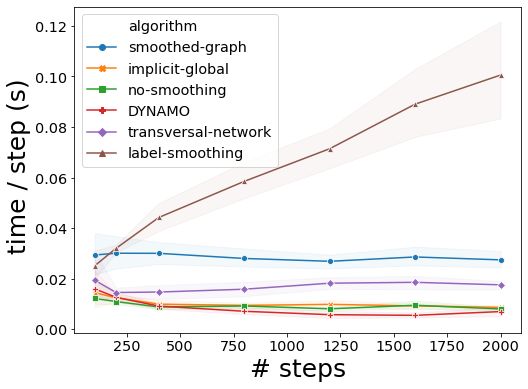

In [187]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

df_stats["running time"] = df_stats["running time"]/df_stats["# steps"]
df_stats = df_stats[df_stats["# steps"]>50]

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["running time"]:
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.lineplot(x="# steps", y=carac, ax=ax,hue="algorithm",style="algorithm",legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("# steps", fontsize=25)
    ax.set_ylabel(" time / step (s)", fontsize=25)
    #ax.set_xticks(np.arange(0.0, 0.51, 0.1))
    #ax.ticklabel_format(axis="y",scilimits=(-1,1),style="sci")


    #ax.figure(figsize=(20,20))
    #handles,labels = ax.get_legend_handles_labels()
    #figlegend = pylab.figure(figsize=(4,3))
    #figlegend.legend(handles,labels,loc="center")
    #figlegend.savefig(dir_or+"/legend.pdf")
    #ax.get_legend().remove()
    ax.get_figure().savefig(dir_or+"/"+carac+"_steps.pdf")





## Secondly by varying the number of nodes

In [161]:
nb_coms = [10,25,50,75,100]
#nb_coms = [10,25]
nb_coms = [75,200]

saved_coms = compute_communities_on_random_graph(mus=[0.2],nb_coms=nb_coms,subsets=[50],iterations=2,operations=5)

---- 0.2
0
generating graph with nb_com =  75


100% (5 of 5) |##########################| Elapsed Time: 0:00:59 ETA:  00:00:00

start smoothed graph


 98% (49 of 50) |####################### | Elapsed Time: 0:00:41 ETA:   0:00:00

start smoothed louvain


 98% (49 of 50) |####################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
0
generating graph with nb_com =  200


100% (5 of 5) |##########################| Elapsed Time: 0:05:25 ETA:  00:00:00

start smoothed graph


 98% (49 of 50) |####################### | Elapsed Time: 0:04:44 ETA:   0:00:05

start smoothed louvain


 98% (49 of 50) |####################### | Elapsed Time: 0:01:27 ETA:   0:00:01

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
1
generating graph with nb_com =  75


100% (5 of 5) |##########################| Elapsed Time: 0:00:42 ETA:  00:00:00

start smoothed graph


 98% (49 of 50) |####################### | Elapsed Time: 0:00:48 ETA:   0:00:00

start smoothed louvain


 98% (49 of 50) |####################### | Elapsed Time: 0:00:15 ETA:   0:00:00

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
1
generating graph with nb_com =  200


100% (5 of 5) |##########################| Elapsed Time: 0:11:06 ETA:  00:00:00

start smoothed graph


 98% (49 of 50) |####################### | Elapsed Time: 0:04:35 ETA:   0:00:05

start smoothed louvain


 98% (49 of 50) |####################### | Elapsed Time: 0:01:46 ETA:   0:00:01

start dynamo
run external code
postprocess
dynamo run
preprocessing MUCHA 
calling external code
sucessfully finished MUCHA 
starting survival graph method 
error computing algos


In [162]:
df_stats = compute_all_stats(saved_coms,detailed=False)

globalID=datetime.datetime.now().strftime("%m-%d-%Y:%I:%M%p")
df_stats.to_csv(dir_or+"/scalability_nodes_"+str(globalID))

(0.2, 0, 75, 50)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 0, 200, 50)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 1, 75, 50)
smoothed-graph
implicit-global
no-smoothing
DYNAMO
transversal-network
label-smoothing
(0.2, 1, 200, 50)
['smoothed-graph', 'implicit-global', 'no-smoothing', 'DYNAMO', 'transversal-network', 'label-smoothing', 'smoothed-graph', 'implicit-global', 'no-smoothing', 'DYNAMO', 'transversal-network', 'label-smoothing', 'smoothed-graph', 'implicit-global', 'no-smoothing', 'DYNAMO', 'transversal-network', 'label-smoothing']


In [191]:
df_stats = load_all_files("scalability_nodes")

12
12
24
24
16
24
12
18
2
6
36
150
18
24


<Figure size 1080x360 with 0 Axes>

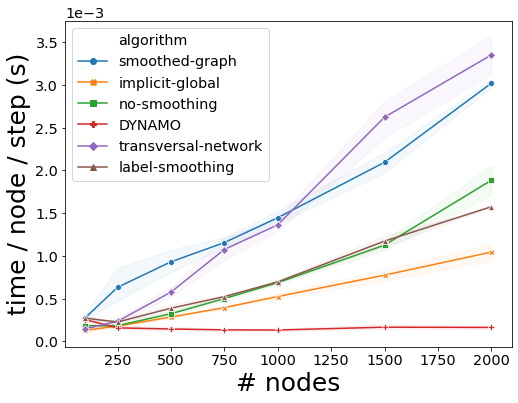

In [192]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

df_stats["#coms"] = df_stats["#coms"]*10
df_stats["running time"] = df_stats["running time"]/(df_stats["# nodes"])/df_stats["# steps"]



#df_stats["#coms"] = df_stats["#coms"]*10
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for carac in ["running time"]:
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.lineplot(x="#coms", y=carac, ax=ax,hue="algorithm",style="algorithm",legend="full",data=df_stats,dashes=False,markers=True,err_kws={"alpha":0.05})#,err_style="bars")
    ax.set_xlabel("# nodes", fontsize=25)
    ax.set_ylabel("time / node / step (s)", fontsize=25)
    #ax.set_xticks(np.arange(0.0, 0.51, 0.1))
    ax.ticklabel_format(axis="y",scilimits=(-1,1),style="sci")


    #ax.figure(figsize=(20,20))
    #handles,labels = ax.get_legend_handles_labels()
    #figlegend = pylab.figure(figsize=(4,3))
    #figlegend.legend(handles,labels,loc="center")
    #ax.get_legend().remove()
    ax.get_figure().savefig(dir_or+"/"+carac+"_nodes.pdf")






In [ ]:
#del methods_to_test["survival_graph"]
#methods_to_test={"DYNMOGA":dynmoga}
df_stats = None
parameters = [3,10,50,100,150,200]
#parameters=[200]
param_name="nb nodes"
#for nb_com in ncoms:
#    (subgraph,subcomsGT) = generate_graph(nb_com,4,15,nb_com*2)
#    dyn_graph_sn = subgraph.to_DynGraphSN(slices=1)
#    GT_as_sn = subcomsGT.to_DynCommunitiesSN(slices=1)

#    for iteration in range(2):
#        subgraph,subcomsGT =subset(dyn_graph_sn,GT_as_sn,50)
#        result = run_all_algos(methods_to_test,subgraph)
#        stats = compute_all_stats(result,subcomsGT,subgraph,iteration)
#        if nb_com==ncoms[0]:
#            df_stats=stats
#        else:
#            df_stats = pd.concat([df_stats,stats])
saved_coms={}
for parameter in parameters:
    print("----",parameter)
    (dyn_graph,GT) = generate_graph(parameter,5,15,20)
    #(dyn_graph,GT) = generate_graph(10,5,10,20,mu=mu)

    dyn_graph_sn = dyn_graph.to_DynGraphSN(slices=1)
    GT_as_sn = GT.to_DynCommunitiesSN(slices=1)
    subgraph,subcomsGT =subset(dyn_graph_sn,GT_as_sn,50)
    
    for iteration in range(2):
            ID = (parameter,iteration)
            saved_coms[ID]={}
            saved_coms[ID]["ID"]={param_name:ID[0]*10,"iteration":ID[1]}
            print(iteration)

            #subgraph = dyn_graph_sn
            #subcomsGT = GT_as_sn

            saved_coms[ID]["graph"]=subgraph
            saved_coms[ID]["GT"]=subcomsGT


            result = run_all_algos(methods_to_test,subgraph)
            saved_coms[ID]["result"]=result

df_stats = compute_all_stats(saved_coms,detailed=False)
            
globalID=datetime.datetime.now().strftime("%m-%d-%Y:%I:%M%p")
df_stats.to_csv("by_nb_com"+str(globalID))

In [ ]:
(dyn_graph,dyn_com) = generate_graph(6,4,15,100)
dyn_graph = dyn_graph.to_DynGraphSN(slices=1)
dyn_com = dyn_com.to_DynCommunitiesSN(slices=1)

for aggreg in [1,5,50,100]:
    dyn_graph_aggreg = dyn_graph.aggregate_sliding_window(aggreg)
    subgraph,_ =subset(dyn_graph_aggreg,dyn_com,50)



    for _ in range(5):
        result = run_all_algos(methods_to_test,subgraph)
        stats = compute_all_stats(result,None,subgraph,aggreg,detailed=False)
        if aggreg==1:
            df_stats=stats
        else:
            df_stats = pd.concat([df_stats,stats])